# Compare Time Domain Survey and VASCA catalogs

In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits

from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

### Load VASCA region

In [2]:
region_name = "TDS_ELAISN1"  #_ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6


### Get TDS & VASCA data and match them positionally

In [3]:
#Select vasca sources, 5 sigma 0.000000573303, 4 sigma 0.00006334, 3 sigma = 0.002699796

sel_flux_cpval = (rg.tt_sources["flux_cpval"]<0.000000573303) * (rg.tt_sources["flux_cpval"]>-0.5)
sel_flux_nxv = rg.tt_sources["flux_nxv"]>0.0006
sel_flux_var = sel_flux_cpval*sel_flux_nxv

sel_assoc_ffactor = rg.tt_sources["assoc_ffactor"]>1.5
sel_assoc_fdiff_s2n = rg.tt_sources["assoc_fdiff_s2n"]>7
sel_assoc = sel_assoc_ffactor * sel_assoc_fdiff_s2n

sel_pos_cpval = rg.tt_sources["pos_cpval"]>1e-10
sel_flux = (rg.tt_sources["flux"]> 0.144543) * (rg.tt_sources["flux"]< 575.43)
sel_quality = sel_pos_cpval * sel_flux

sel_vasca = sel_flux_var * sel_quality + sel_assoc * sel_quality #+ 
rg.tt_sources["sel"][:]=sel_vasca

#sel_vasca = rg.tt_sources["sel"]
tt_vasca = rg.tt_sources[sel_vasca]

print(f"Selected {len(tt_vasca)} out of {len(rg.tt_sources)} sources")
# Print cut efficiencies
#def print_cuteff(new_sel,pre_sel,cut_label):
#    sel_temp = pre_sel*new_sel
#    print(f"Selection efficiency {cut_label}: {round(100*sel_temp.sum()/pre_sel.sum(),2)}%")
#print_cuteff(sel_flux_cpval,sel_flux_cpval*0+1,"flux_cpval")
#print_cuteff(sel_pos_cpval,sel_flux_cpval,"pos_cpval")
#print_cuteff(sel_flux_nxv,sel_pos_cpval*sel_flux_cpval,"nxv")

#Read TDS
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all[sel_elai] #tt_tds_all #
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

#Match VASCA-TDS
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

match_dist = 10 * uu.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

display(2849 in tt_vasca[:]["rg_src_id"])
display(tt_tds[:2])

Selected 275 out of 37951 sources


True

recno,ID,ra,dec,l_mlow,mlow,l_Dmmax,Dmmax,l_sigint,sigint,l_Sd,Sd,l_Sy,Sy,LC,Mph,rmag,OT,z,X,Class,rg_src_id,vasca_idx,vasca_dist,vasca_match
,,deg,deg,,mag,,mag,,mag,,mag,,mag,,,mag,,,,,,,arcsec,
int32,bytes16,float64,float64,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,float32,bytes1,bytes3,float32,bytes3,float32,bytes1,bytes12,int32,int64,float64,bool
3,ELAISN1_MOS15-02,242.0397,54.3586,>,22.89,>,4.03,,1.37,,0.84,,2.93,V,pt,22.51,QSO,--,,CV,661,5,0.4526,True
4,ELAISN1_MOS15-09,242.3685,53.6738,>,23.03,>,4.02,,1.23,,0.01,,2.15,F,ext,21.05,,--,,Galaxy Trans,23910,184,1.5450,True


In [4]:
sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))
print("Nr. associated sources VASCA/TDS:",sel_vmt.sum(),"/",sel_tmv.sum())
print("Fraction of associated VASCA/TDS sources:",sel_vmt.sum()/len(tt_vasca),"/",sel_tmv.sum()/len(tt_tds))

ids_tds = tt_tds["ID"].data.astype(dtype=str)
sel_tds_mos15 = (np.char.find(ids_tds, 'MOS15') > -1)
tt_tds_mos15 = tt_tds[sel_tds_mos15]
print("Total Nr of TDS sources from MOS15:",len(tt_tds_mos15))
display(tt_tds_mos15[tt_tds_mos15["vasca_match"]==False]["recno","ID","ra","dec"])

Nr. sources VASCA/TDS : 275 / 160
Nr. associated sources VASCA/TDS: 84 / 85
Fraction of associated VASCA/TDS sources: 0.3054545454545455 / 0.53125
Total Nr of TDS sources from MOS15: 26


recno,ID,ra,dec
,,deg,deg
int32,bytes16,float64,float64
59,ELAISN1_MOS15-10,242.3832,53.6801
127,ELAISN1_MOS15-16,242.7175,53.7547
184,ELAISN1_MOS15-24,243.0512,54.2599
212,ELAISN1_MOS15-11,242.4293,54.3621
307,ELAISN1_MOS15-03,242.1960,54.0721
390,ELAISN1_MOS15-22,242.8843,53.5921
417,ELAISN1_MOS15-18,242.7775,53.9643
441,ELAISN1_MOS15-13,242.4726,53.6579


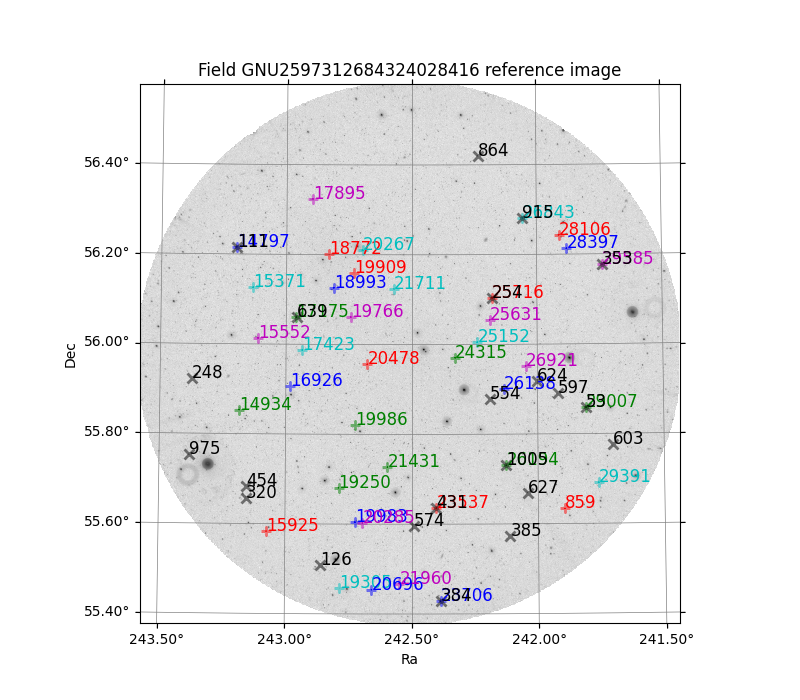

In [5]:
#PS_ELAISN1_MOS15 is field_id GNU2597664528044916736 (TDE PS1-10jh field)
field_id = rg.tt_fields["field_id"][0]
fd = rg.get_field(field_id=field_id, load_method="FITS", add_field=False)

#from astropy.coordinates import Angle, SkyCoord
#from regions import CircleSkyRegion
#center = SkyCoord(243.0512, 54.2599, unit='deg')
#radius = Angle(0.03, 'deg')
#region = CircleSkyRegion(center, radius)

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, src_id="rg_src_id", sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

plot_tds = {"marker":"x","color":"k"}
ax = vvis.plot_sky_sources(tt_tds, src_id="recno",src_kwargs=plot_tds, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs))

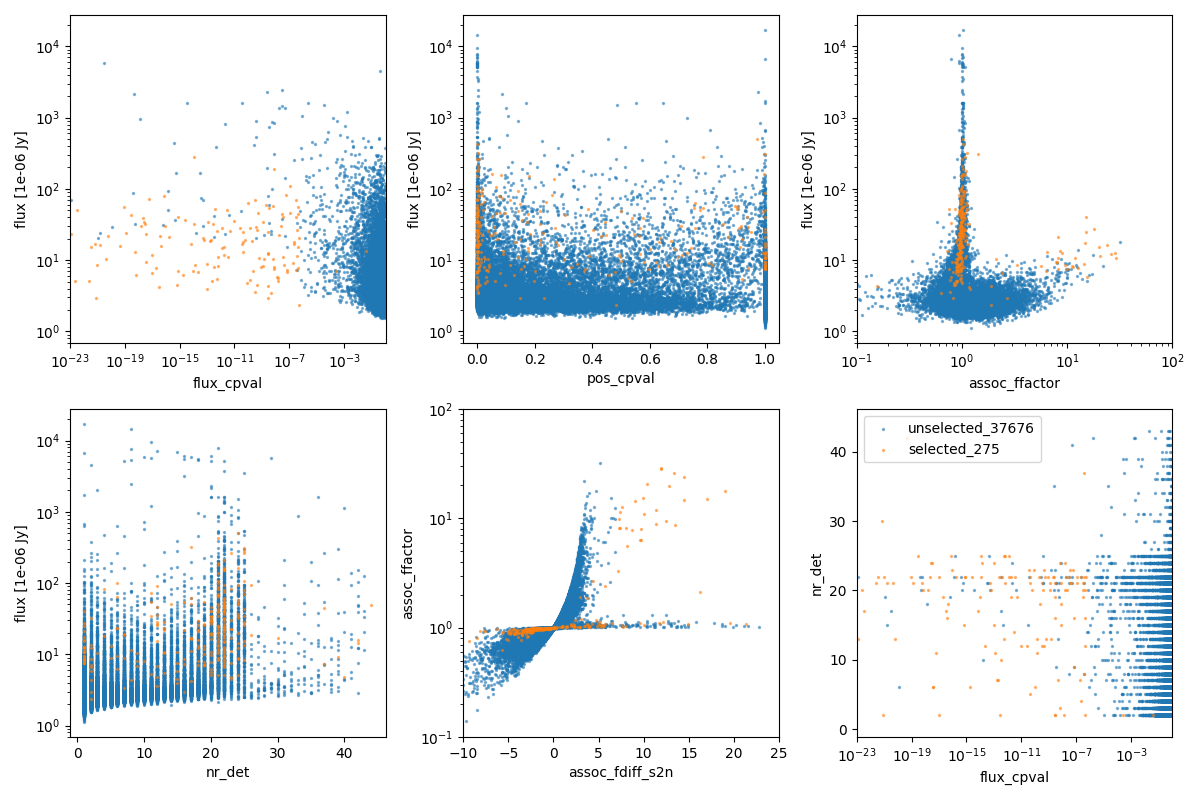

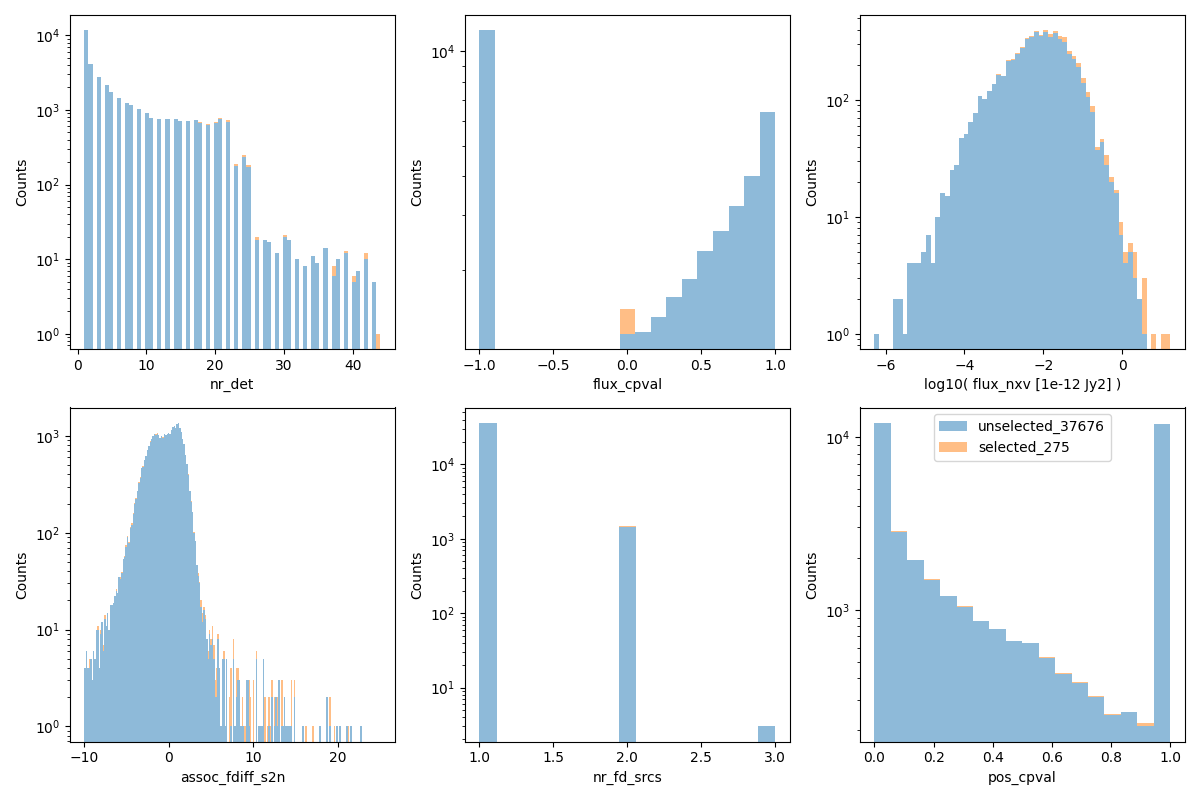

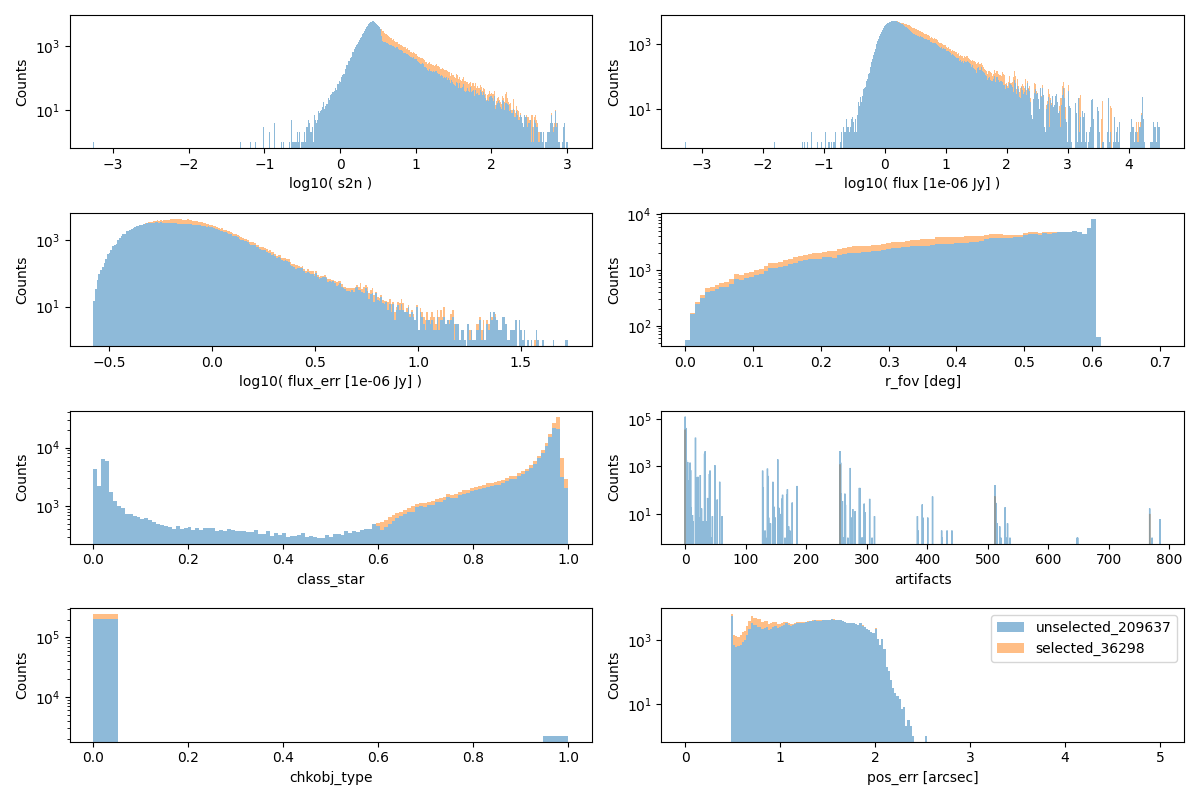

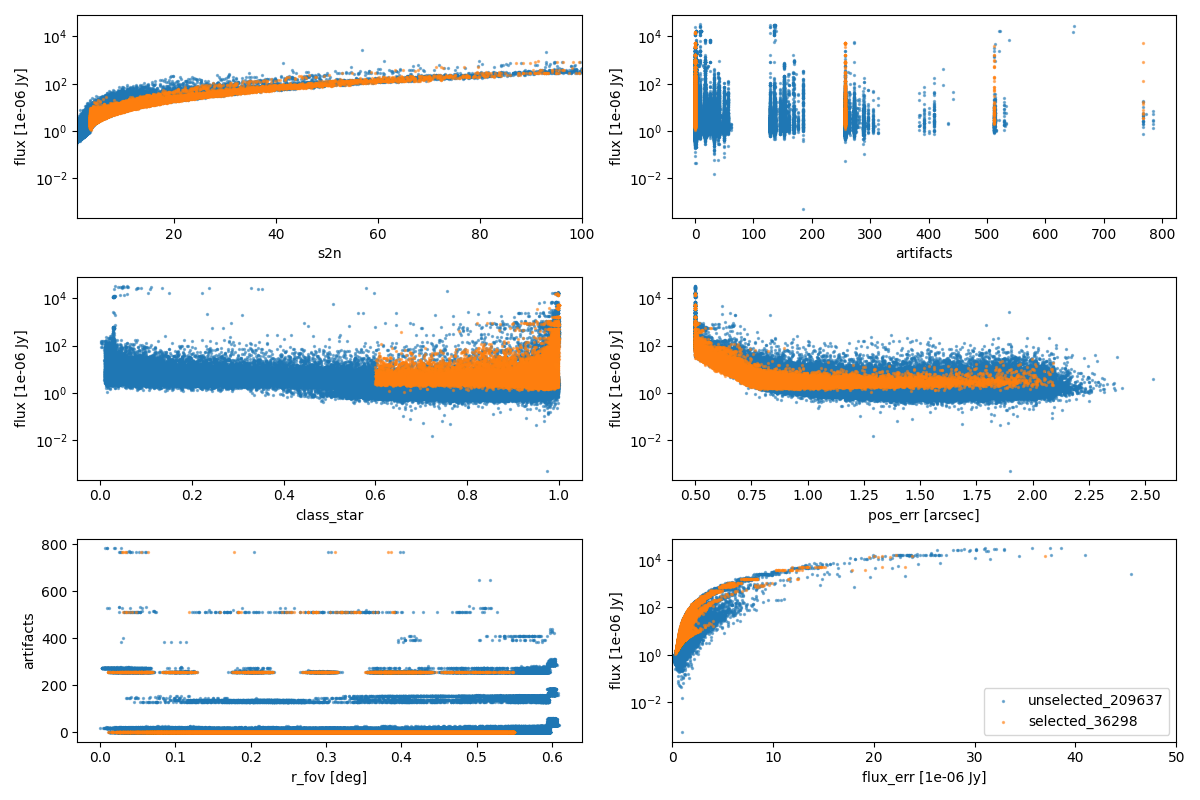

In [6]:
import vasca.visualization as vvis
_= vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
_= vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
_= vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist")
_= vvis.plot_pipe_diagnostic(fd, "tt_detections", "scatter")

fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,assoc_id,assoc_dist,assoc_ffactor,assoc_fdiff_s2n,sel,rg_fd_id,coadd_src_id,nr_fd_dets
,,,deg,deg,arcsec,,arcsec2,,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,,arcsec,,,,,,
int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,bool,int32,int32,int32
-1,2,0,244.52023862123562,54.63649147207276,0.45694694,-5.258287e-13,0.20304562,0.2916895,0.48608238,2.7935953,0.17730692,-0.0066277613,0.011586736,0.6687965,0.18301316,0.08242655,0.31479418,0.08242655,-100.0,22.784592,0.066812515,-1,-1.0,-100.0,-10000.0,False,-1,0,-1
-1,2,0,244.5061204340321,54.63441429745079,0.5344486,-5.4254457e-12,0.13130085,0.40739435,0.22731662,0.6526119,0.1003184,-0.042548876,0.0030349845,0.70487213,0.14345297,0.047546506,0.29588148,0.047546506,-100.0,24.363363,0.15524864,-1,-1.0,-100.0,-10000.0,False,-1,1,-1
-1,2,0,244.50518993181277,54.64123986176389,0.38052365,-1.4303308e-12,0.17234819,0.19425717,0.5948282,7.370797,0.16339807,2.3256043e-05,0.05517511,0.31170535,1.0234361,0.18230963,0.7494488,0.18230963,-100.0,21.731215,0.023805618,-1,-1.0,-100.0,-10000.0,True,-1,2,-1
-1,2,0,244.48658810494769,54.65111267099028,0.4680585,-4.640389e-12,0.9657999,0.032982297,2.1994836,1.9798506,0.13026328,0.007153678,0.06486165,0.18443021,1.7615588,0.23048174,1.0617257,0.23048174,-100.0,23.158419,0.06918335,-1,-1.0,-100.0,-10000.0,True,-1,3,-1
-1,2,0,244.48497388052496,54.63995240270246,0.45345017,-1.6889361e-12,0.18744643,0.26261225,0.4555023,0.9255288,0.088413686,-0.018246762,5.574635e-06,0.9849352,0.00035652978,0.0016877651,0.013424494,0.0016877651,-100.0,23.984024,0.09905815,-1,-1.0,-100.0,-10000.0,True,-1,4,-1
-1,2,0,244.48176527079315,54.63758946894127,0.45203537,-5.3455174e-12,0.12124977,0.41125834,0.29662707,1.2272745,0.09864887,0.037203312,0.0757346,0.049905937,3.8446164,0.2158798,1.4603316,0.2158798,-100.0,23.677645,0.083940506,-1,-1.0,-100.0,-10000.0,False,-1,5,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,1,0,240.32745872709873,55.38720337631857,0.74050295,-100.0,-1296000000.0,1.0,-1.0,0.4291516,0.09348143,-100.0,-100.0,-1.0,-1.0,0.0,0.0,0.0,-100.0,24.818474,0.21396446,-1,-1.0,-100.0,-10000.0,False,-1,114990,-1


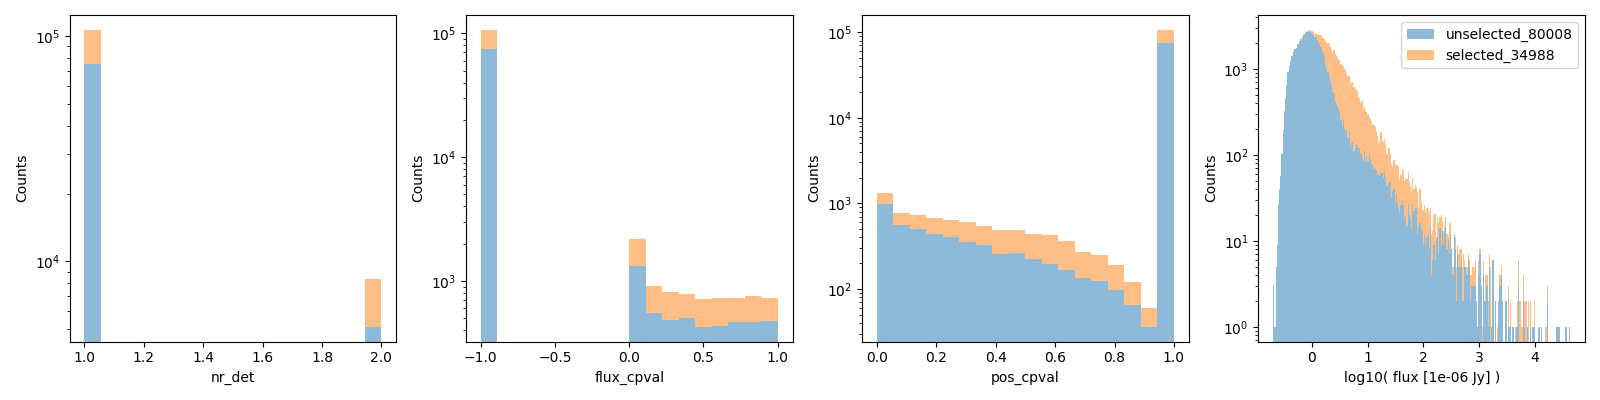

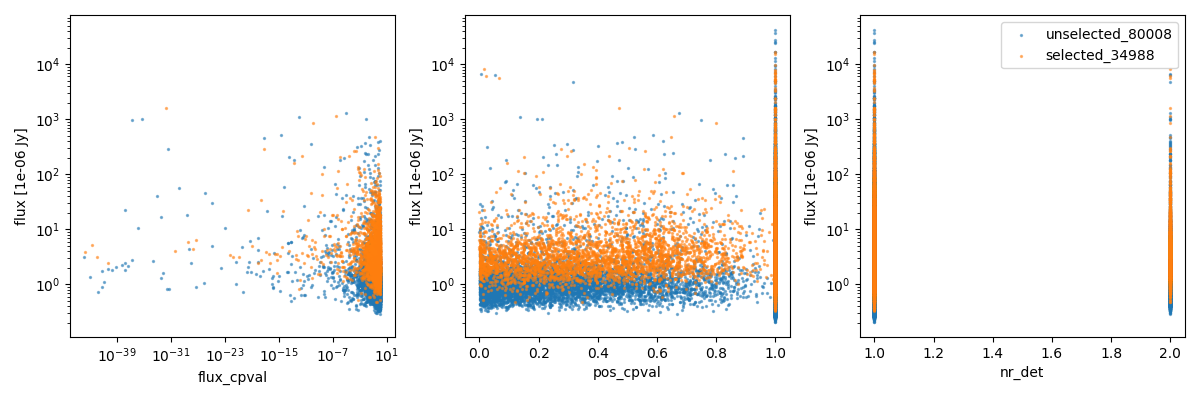

In [7]:
#rg.tt_coadd_sources["sel"][:]=rg.tt_coadd_sources["flux"]/rg.tt_coadd_sources["flux_err"]>5
display(rg.tt_coadd_sources)
_ = vvis.plot_pipe_diagnostic(rg, "tt_coadd_sources", plot_type="hist", fig_size=(16, 4))
_ = vvis.plot_pipe_diagnostic(rg, "tt_coadd_sources", plot_type="scatter", fig_size=(12, 4))